In [4]:
from music21 import *
import os
import random

In [5]:
# # Nathan's musescore path settings
# from music21 import environment
# environLocal = environment.Environment('converter.subConverters')
# environLocal['musescoreDirectPNGPath'] = 'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe'

## Load dataset

In [8]:
DATASET_MAX = 10
dataset_dir = './dataset'
dataset = []
for filename in os.listdir(dataset_dir):
    if filename.endswith('.xml') or filename.endswith('.musicxml'):
        c = converter.parse(dataset_dir + '/' + filename)
        dataset.append(c)
    if len(dataset) >= DATASET_MAX:
        break
print(len(dataset))

10


In [22]:
# transpose each piece to the same key (C or Cm)
def transpose_to_C(s):
    k = s.flatten().getElementsByClass(key.Key).first()
    if k is None:
        k = s.analyze('key')
    i = interval.Interval(k.tonic, pitch.Pitch('C'))
    return s.transpose(i)

dataset_transposed = []
for s in dataset:
    try:
        dataset_transposed.append(transpose_to_C(s))
    except Exception as e:
        print(e)
        pass

print(len(dataset_transposed))

10


In [10]:
dataset_transposed[1].analyze('key')

<music21.key.Key of C major>

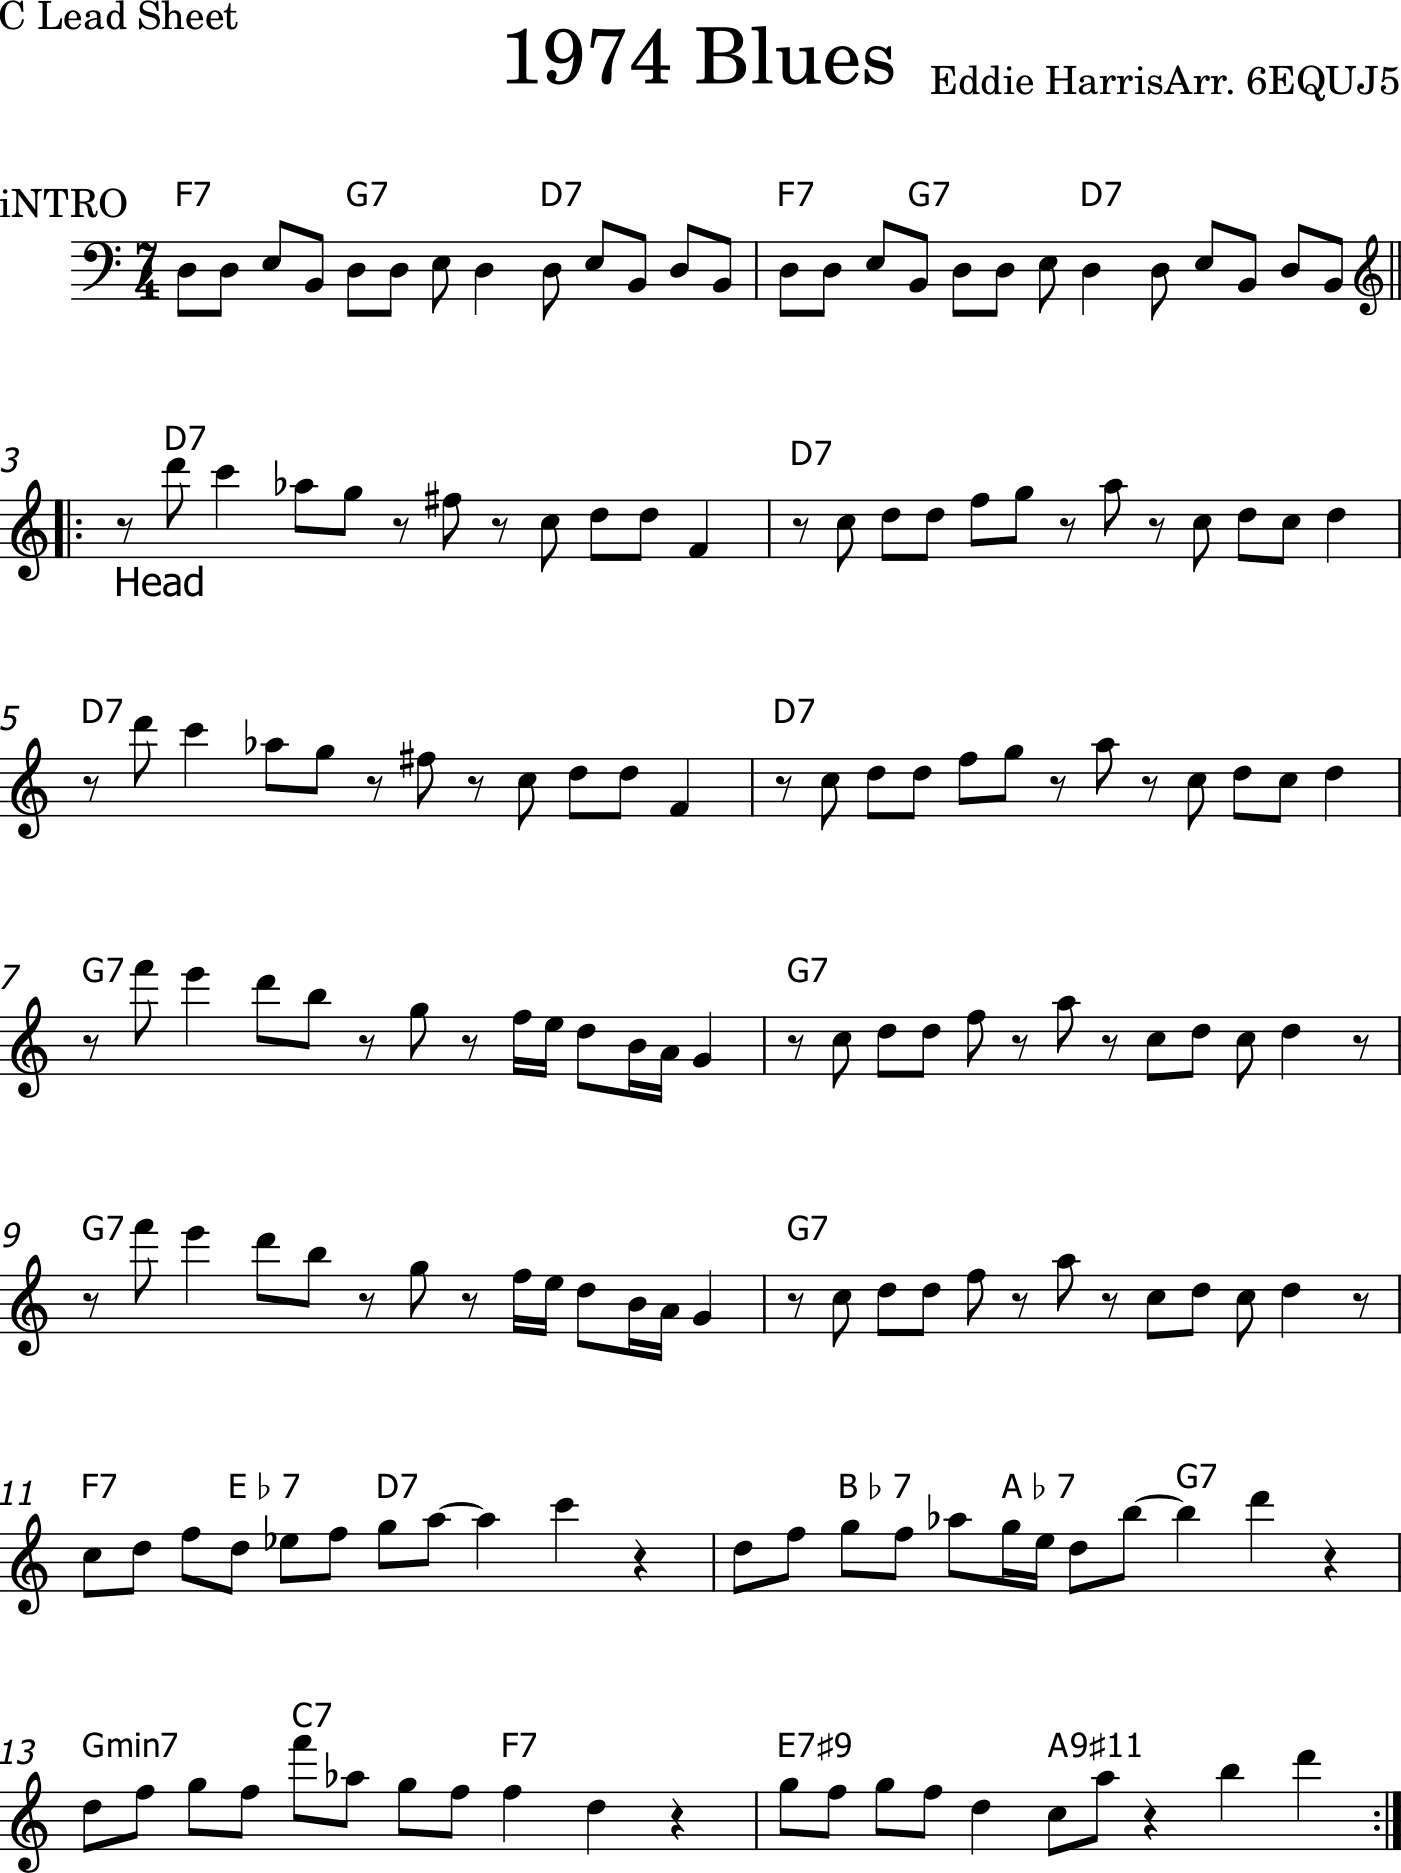

In [11]:
dataset[1].show()

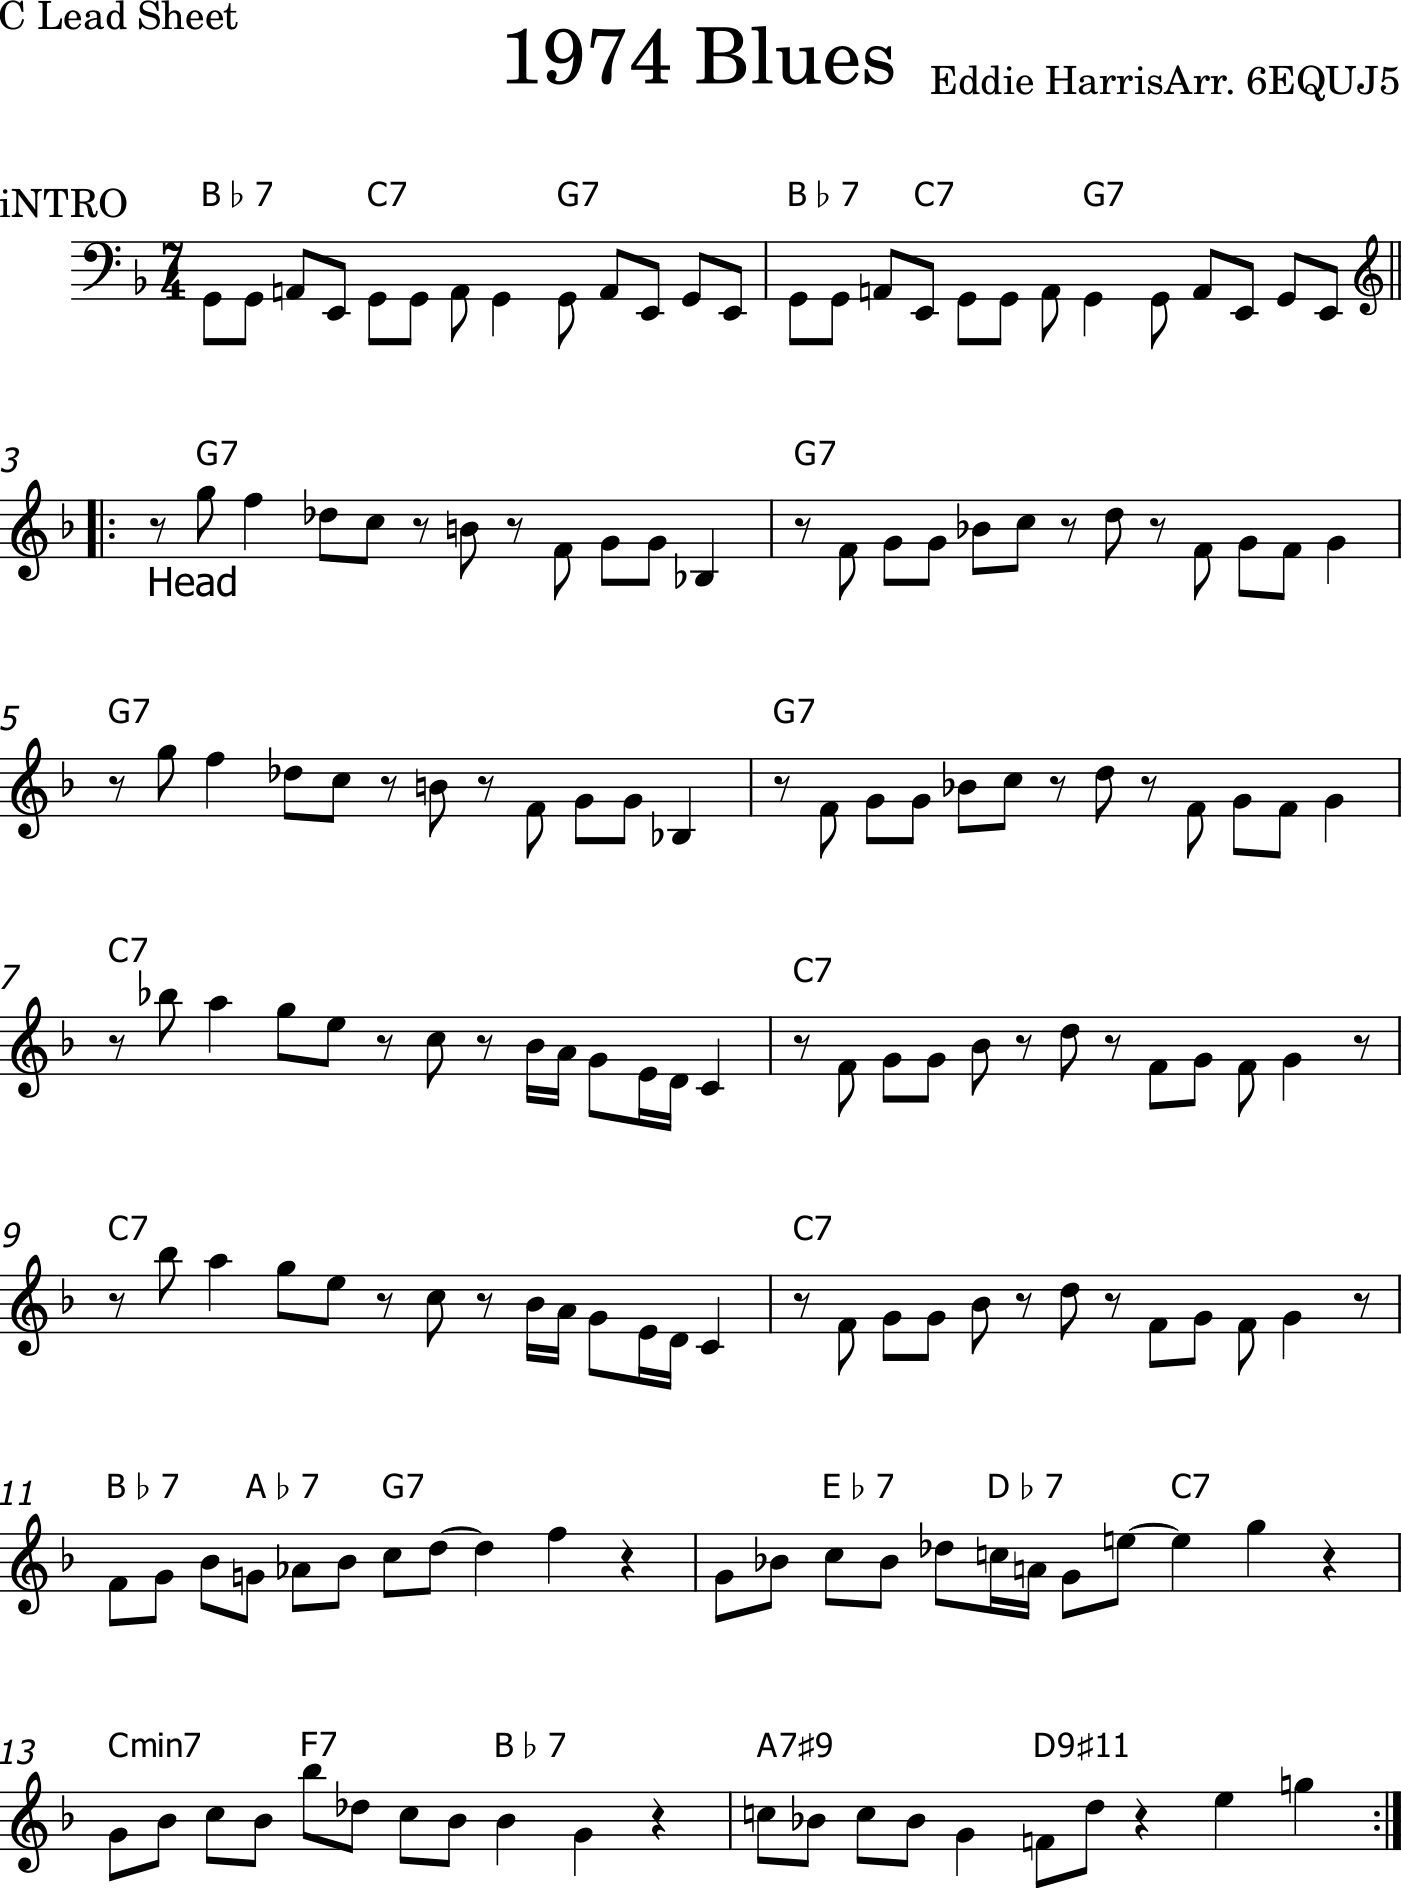

In [12]:
(dataset_transposed[1]).show()

## Feature extract

In [24]:
def extract_chords_and_durations (s: stream.Score):
    '''
    Given a score, with properly notated ChordSymbols,
    returns a list of its chord symbols and durations, 
    eg [(ChordSymbol B-7, 2.0), (ChordSymbol G, 4.0)].
    Useful for hashing.
    '''
    chords_and_durs = [] 

    prev_chord_symbol = None
    prev_chord_symbol_offset = 0

    for chord_symbol in s.flatten()[harmony.ChordSymbol]:
        if prev_chord_symbol is not None:
            chord_and_dur = (prev_chord_symbol, chord_symbol.offset-prev_chord_symbol_offset)
            chords_and_durs.append(chord_and_dur)
        prev_chord_symbol = chord_symbol
        prev_chord_symbol_offset = chord_symbol.offset

    return chords_and_durs

## Generate chord prog (ignore the hashing stuff)

In [ ]:
def hash_chord_symbol(chord_symbol):
    '''
    Input: a chord symbol
    Output: a relevant string, containing features as desired
    ! for now, we output the merely the chordSymbol's figure (eg B-7)
    '''

# hash_chord_symbol()

In [46]:
def hash_rhythm(rhythm):
    '''
    Input: list (e.g. [{measure: 0, beat: 0}, {measure: 1, beat: 3}, {measure: 2, beat: 0}])
    Output: string (e.g. 'M1B0-M1B3-M2B0')
    '''
    hashes = []
    for r in rhythm:
        hashes.append(
            'M' + str(r['measure']) + 'B' + str(r['beat'])
        )
    return '-'.join(hashes)

hash_rhythm([{'measure': 0, 'beat': 0}, {'measure': 1, 'beat': 3}, {'measure': 2, 'beat': 0}])

'M0B0-M1B3-M2B0'

In [47]:
def unhash_rhythm(rhythm_hash):
    '''
    Input: a hashed rhythm
    Output: the unhashed rhythm
    '''
    unhashed = []
    for subhash in rhythm_hash.split('-'):
        m, b = subhash[1:].split('B')
        unhashed.append({
            'measure': m,
            'beat': b
        })
    return unhashed
        
unhash_rhythm('M0B0-M1B3-M2B0')

[{'measure': '0', 'beat': '0'},
 {'measure': '1', 'beat': '3'},
 {'measure': '2', 'beat': '0'}]

In [138]:
def generate_progression(pairs):
    '''
    Inputs:
        list of tuples (progression, rhythm) where progression is a tuple of chord names (e.g. ('ii', 'V', 'I'))
            and rhythm is defined above (unhashed)
    Outputs:
        a tuple (progression, rhythm, rhythm_choosing_func)
    '''
    progs = []
    rhythms_given_prog_len = {}
    for prog, rhythm in pairs:
        progs.append(prog)
        if len(prog) not in rhythms_given_prog_len:
            rhythms_given_prog_len[len(prog)] = []
        rhythms_given_prog_len[len(prog)].append(rhythm)
        
    def choose_rhythm(prog):
        return random.choice(rhythms_given_prog_len[len(prog)])
    
    prog = random.choice(progs)
    rhythm = choose_rhythm(prog)
    return prog, rhythm, choose_rhythm

prog = generate_progression([
    (('ii', 'V', 'I'), [{'measure': 0, 'beat': 0}, {'measure': 1, 'beat': 3}, {'measure': 2, 'beat': 0}]),
    (('ii', 'V', 'I'), [{'measure': 0, 'beat': 0}, {'measure': 1, 'beat': 0}, {'measure': 2, 'beat': 0}]),
    (('I', 'V'), [{'measure': 0, 'beat': 0}, {'measure': 2, 'beat': 2}]),
    (('I', 'V7'), [{'measure': 0, 'beat': 0}, {'measure': 2, 'beat': 0}]),
])
prog

(('I', 'V'),
 [{'measure': 0, 'beat': 0}, {'measure': 2, 'beat': 2}],
 <function __main__.generate_progression.<locals>.choose_rhythm(prog)>)

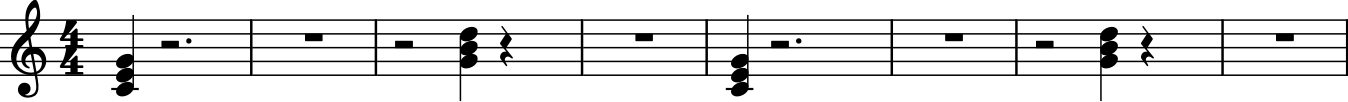

In [139]:
def restify(m):
    def insert_rest(offset, length):
        r = note.Rest()
        r.quarterLength = length
        m.insert(offset, r)
        
    offsets = []
    for o in m:
        offsets.append(o.offset)
        
    offsets = sorted(offsets)
    if len(offsets) == 0:
        insert_rest(0, 4)
        return m
    
    if offsets[0] > 0:
        insert_rest(0, offsets[0])
    
    for i in range(len(offsets)-1):
        insert_rest(offset[i]+1, offset[i+1] - (offset[i] + 1))
        
    if offsets[-1] < 3:
        insert_rest(offsets[-1], 3-offsets[-1])
    
    return m

def generate_chords(progression, length, k=key.Key('C')):
    '''
    Generate a Part that is the chord progression repeated for a quarterlength of length.
    '''
    p = stream.Part()
    p.append(meter.TimeSignature('4/4'))
    chords, rhythm, _ = progression
    chord_idx = 0
    for i in range(length // 4):
        m = stream.Measure()
        
        measure_idx = i % 4
        for j, symbol in enumerate(chords):
            if rhythm[j]['measure'] == measure_idx:
                # place a chord here
                chrd = roman.RomanNumeral(symbol, k)
                m.insert(rhythm[j]['beat'], chrd)
        
        restify(m)
        p.append(m)
    
    return p

p = generate_chords(prog, 4*8)
p.show()

## Generate chords, attempt 2

In [17]:
chords_and_durations = extract_chords_and_durations (dataset_transposed[1])


In [31]:
print(chords_and_durations[0][0].figure)

B-7


In [23]:
from collections import Counter
from more_itertools import windowed

markov_dict = dict()

for window in windowed(chords_and_durations,3):
    dict_key = window[:-1]
    dict_val = window[-1]
    if dict_key not in markov_dict:
        markov_dict[dict_key] = Counter()
    rel_count = markov_dict[dict_key]
    rel_count[markov_dict(dict_val)] += 1

print(markov_dict)

TypeError: unhashable type: 'ChordSymbol'

In [20]:
t = (1,2,3)
t[:-1]

(1, 2)

## Generate melody
#### Assumes 4/4

In [224]:
def get_chord_by_offset(progression, offset):
    offset = offset % (4*4)
    measure = offset // 4
    beat = offset - (4*measure)
    
    chords, rhythm, _ = progression
    for i in range(len(chords)):
        if rhythm[i]['measure'] == measure and rhythm[i]['beat'] <= beat:
            return chords[i]
        if rhythm[i]['measure'] > measure:
            return chords[i-1]
        
    return chords[-1]

def init_notes(progression, melody_probs, num_notes, k=key.Key('C')):
    random_start = random.choice(list(melody_probs.keys()))
    return [random_start[0], random_start[1]], 0

    prob_rest = 0.1
    offset = 0
    notes = []
    for i in range(num_notes):
        symbol = get_chord_by_offset(progression, offset)
        chrd = roman.RomanNumeral(symbol, k)
        pitch_choice = random.choice(chrd.pitches)
        pitch_choice.octave = random.choice([4,5])
        note_choice = random.choices([pitch_choice.name, 'r'], weights=[1-prob_rest, prob_rest])[0]

        note_len = random.choice([0.25, 0.5, 1])
        offset += note_len
        notes.append((note_choice, note_len))
        
        
    return notes, offset
    

def get_chord_to_notes(melody_probs):
    c_to_n = {}
    for note_2, note_1, chrd in melody_probs:
        if chrd not in c_to_n:
            c_to_n[chrd] = []
        c_to_n[chrd].append((note_2, note_1, chrd))
    return c_to_n

def generate_melody_notes(progression, melody_probs, length, k=key.Key('C')):
    '''
    Generate a the notes for a melody for a given progression. The length of the part in quarter notes should be 'length'.
    
    melody_probs: dict mapping 2 notes and the current chord to a list of notes. 
                    The 2 notes are supposed to be 2 notes preceeding an offset, and the chord should be the chord that is 
                    being played at that offset.
    '''
    chord_to_notes = get_chord_to_notes(melody_probs)
    # Given current chord and last 2 notes, generate this note
    # note := (pitch, duration); pitch := B3, C4, D#4... r for rests; duration := some number
    # melody_probs := dict[(note, note, chord)] => [note, note, ...]
    notes, offset = init_notes(progression, melody_probs, 2) #[], 0 # TODO: initialize somehow
    offsets = []
    while offset < length:
        note_2, note_1 = notes[-2], notes[-1]
        chrd = get_chord_by_offset(progression, offset)
        
        if (note_2, note_1, chrd) in melody_probs:
            note_choices = melody_probs[(note_2, note_1, chrd)]
        else:
            # should probably sample from melody_probs
            key_ = random.choice(chord_to_notes[chrd])
#             pitches = roman.RomanNumeral(chrd, k).pitches
#             note_len = random.choice([0.5])
#             note_choices = [(p.name, note_len) for p in pitches]
            note_choices = melody_probs[key_]
            
        note_0 = random.choice(note_choices)
        notes.append(note_0)
        offsets.append(offset)
        offset += note_0[1]
        
    melody = [(notes[i+2], offsets[i]) for i in range(len(offsets))]
    return melody

melody_notes = generate_melody_notes(prog, {
    (('C', 0.5), ('E', 0.5), 'I'): [('G', 0.5)],
    (('E', 0.5), ('G', 0.5), 'I'): [('r', 0.5)],
    (('G', 0.5), ('r', 0.5), 'I'): [('C', 0.5)],
    (('r', 0.5), ('C', 0.5), 'I'): [('E', 0.5)],
    (('G', 0.5), ('B', 0.5), 'V'): [('D', 0.5)],
    (('B', 0.5), ('D', 0.5), 'V'): [('F', 0.5)],
}, 4*8)

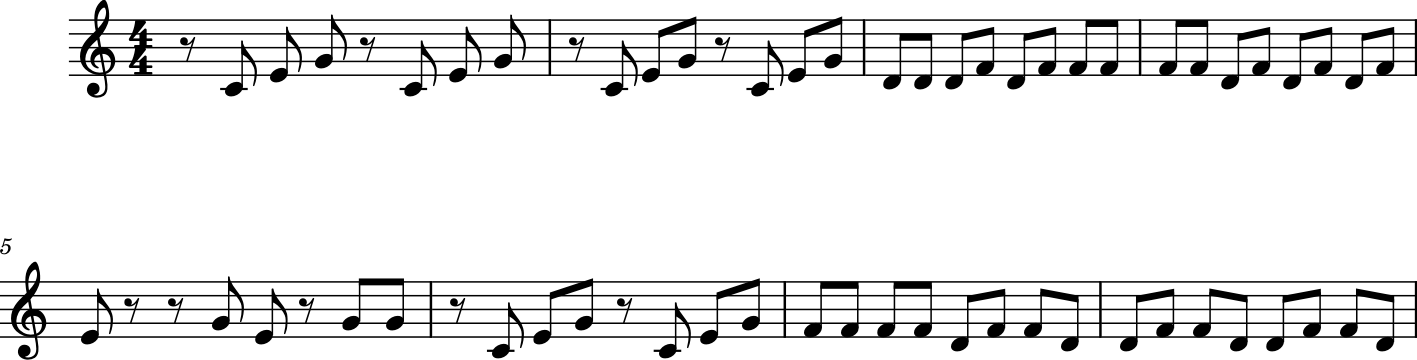

In [225]:
def generate_melody(notes, length):
    '''
    Generate a Part from the melody notes.
    '''
    p = stream.Part()
    p.append(meter.TimeSignature('4/4'))
    
    measure_num = 0
    m = stream.Measure()
    
    for note_def, offset in notes:
        if int(offset // 4) != measure_num:
            for _ in range(int((offset // 4)) - measure_num):
                p.append(m)
                m = stream.Measure()
            measure_num = int(offset // 4)
        
        name, note_len = note_def
        
        if name == 'r':
            n = note.Rest()
        else:
            n = note.Note(name)
        n.quarterLength = note_len
        m.insert(offset % 4, n)
    p.append(m)
    return p



melody = generate_melody(melody_notes, 4*8)
melody.show()

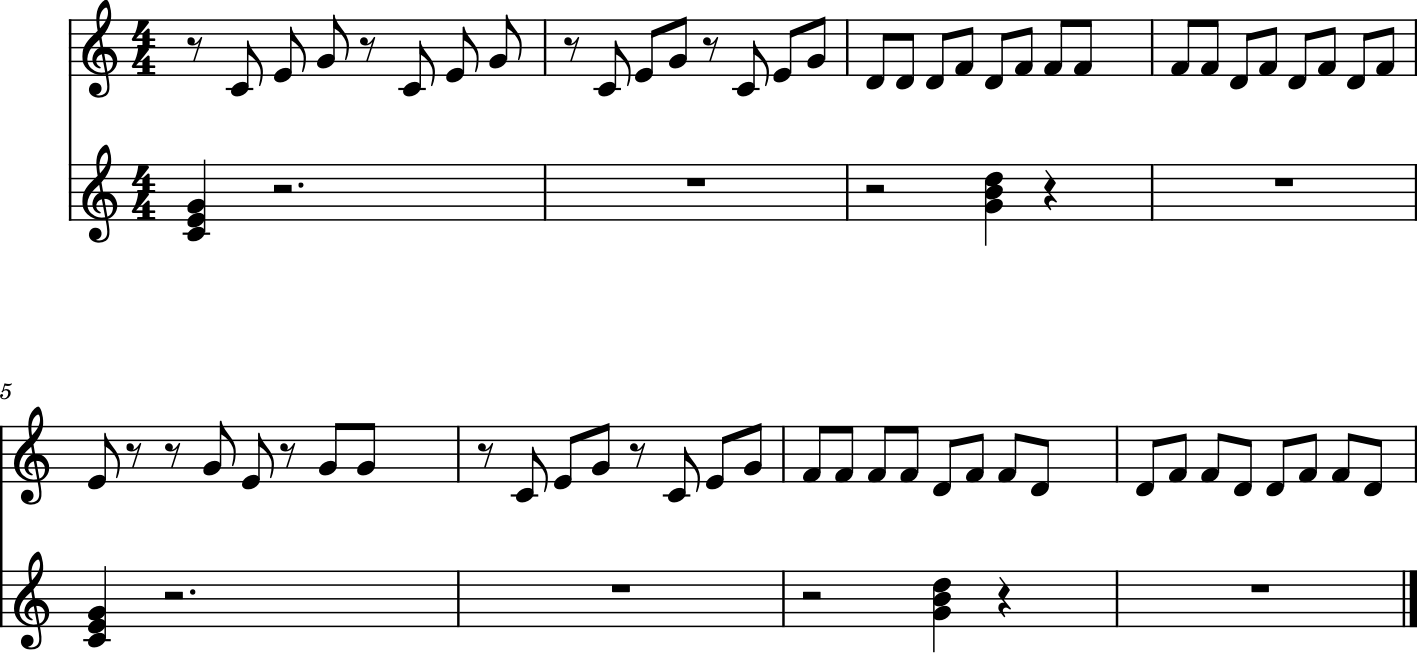

In [226]:
def generate_score(melody, chords):
    score = stream.Score()
    score.append(melody)
    score.append(chords)
    return score

score = generate_score(melody, p)
score.show()